# Iskanje besed, specifičnih za dokumente z uporabo metod na grafih besed

Tokrat bomo poskusili specifične besede v dokumentu določiti z uporabo metod na grafih. Uporabili bomo metodi [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf) in [RAKE](https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents). Metodi zgradita graf sopojavitev besed ter na podlagi grafa točkuje besede in fraze.

In [1]:
import string

import pandas as pd
from textsemantics.server_api import ServerAPI
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
import rake
from IPython.display import display_html, display, Markdown

from textsemantics.specific_words import prepare_embeddings, text_rank_keywords

In [2]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

Iz seznama predlogov vladi izberemo zadnjih 100 dokumentov in jih preprocesiramo.

In [3]:
def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans({punct: " " for punct in string.punctuation}))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
metadata = api.get_metadata('predlogi-vladi', sample_size=100, sampling_strategy='latest')
stop_path = "utils/slovenian-stopwords.txt"

metadata['text'] = api.get_texts(urls=metadata['text'])
metadata = metadata[metadata["text"].apply(lambda x: len(x) > 50)]
texts = metadata['text'].values
tokens_list = preprocess(texts)

Izberemo, koliko najvišje rangiranih besed nas zanima.

In [4]:
num_of_words = 5

Pripravimo funkciji za izračun specifičnih besed ter funkcijo za prikaz besedil in specifičnih besed.

In [5]:
def rake_keywords(text):
    rake_object = rake.Rake(stop_path, max_words_length=1)
    return rake_object.run(text)

def display_document_and_specific_words(doc_ind): 
    title = f"### {metadata.iloc[doc_ind]['title']}"
    display(Markdown('\n'.join((title, texts[doc_ind]))))
    
    # text rank
    top_words_text_rank = text_rank_keywords(
        tokens=[tokens_list[doc_ind]], num_words=num_of_words
    )[0]
    # rake
    top_words_rake = rake_keywords(texts[doc_ind])
        
    display_side_by_side(
        pd.DataFrame(top_words_text_rank[:num_of_words], columns=["Words TextRank", "Score"]),
        pd.DataFrame(top_words_rake[:num_of_words], columns=["Word RAKE", "Score"])
    )

Poglejmo dva dokumenta in 5 najbolj specifičnih besed, ki jih najde vsaka od metod.

In [6]:
display_document_and_specific_words(4)

### Sprememba stopnje DDV za stanovanjske nepremičnine
Trenutna obdavčitev je 9,5% za stanovanja do 120m2 in hiše do 250m2. Če površina presega cenzus, se na celotno ceno obračuna DDV po stopnji 22%. Posledično je stanovanje površine 121m2 več kot dvakrat bolj obdavčeno, kot stanovanje površine 119m2, kar je absurdno.
Predlagam, da se obdavčitev spremeni tako, da je površina do 120m2 stanovanja oz. 250m2 hiše vedno obdavčena po 9,5%. Površina, ki presega cenzus, pa naj bo višje obdavčena.

,Words TextRank,Score
0,obdavčen,0.389836
1,obdavčitev,0.320819
2,stanovanje,0.320819
3,površina,0.301328
4,cenzus,0.246738
,Word RAKE,Score
0,hiše,4.0
1,posledično,4.0
2,površina,4.0
3,stanovanja,1.0


In [7]:
display_document_and_specific_words(13)

### Videvanja z partnerjem z tujine med epidemijo.
Predlagam, da se kot izjema za prehajanje regije, občine ali državne meje, uvede tudi vzdrževanje stikov z partnerji iz tujine. Sam, kot tudi drugi smo namreč zaradi tega prizadeti, saj nas veliko živi ob meji s Hrvaško na primer, 15 min vožnje stran eden od drugega, a zaradi restriktivnih srečanje ni možno, čez Kolpo si pa lahko mahamo. Je bil 1. Val dovolj, da se nisem mogel videti s punco, katere tudi skoraj nisem prepoznal, po 2 mesecih razdvojenosti. Lp

,Words TextRank,Score
0,meja,0.291722
1,prepoznati,0.190220
2,mesec,0.190220
3,izjema,0.188040
4,prehajanje,0.188040
,Word RAKE,Score
0,občine,4.0
1,hrvaško,4.0
2,možno,4.0
3,predlagam,1.0


## Dendrogram s specifičnimi besedami

Sedaj, ko imamo postopek za računanje specifičnih besed, lahko te prikažemo v dendrogramu, ki prikazuje podobnosti med dokumenti. Ker bi bil dendrogram z vsemi dokumenti preobsežen, se odločimo za dokuemnte, ki smo jih že obravnavali v zvezku `03_02_distances_and_similarities`.

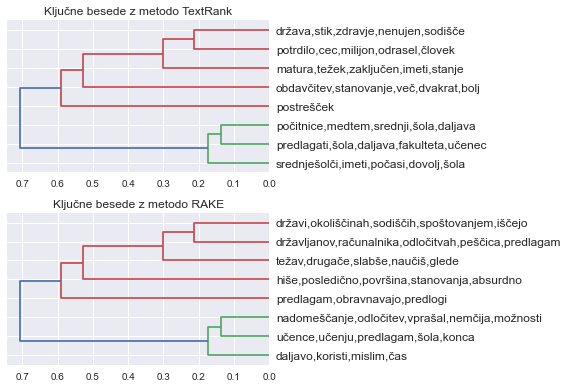

In [8]:
idx = [7, 18, 20, 30, 1, 2, 3, 4]

# dendrogram
plt.style.use('seaborn')
emb, _, _, _ = prepare_embeddings([tokens_list[i] for i in idx])
dist_mat = 1 - cosine_similarity(emb)
linkage = ward(dist_mat)

# specific words TextRank
spec_words_text_rank = [text_rank_keywords(tokens=[tokens_list[i]])[0] for i in idx]
spec_words_text_rank = [",".join(w for w, _ in ws[:5]) for ws in spec_words_text_rank]
# specific words rake
spec_words_rake = [rake_keywords(texts[i]) for i in idx]
spec_words_rake = [",".join(w for w, _ in ws[:5]) for ws in spec_words_rake]
plt.subplot(2, 1, 1)
plt.title("Ključne besede z metodo TextRank")
dendrogram(
    linkage, color_threshold=0.6, 
    labels=spec_words_text_rank,
    orientation="left"
)
plt.subplot(2, 1, 2)
plt.title("Ključne besede z metodo RAKE")
dendrogram(
    linkage, color_threshold=0.6, 
    labels=spec_words_rake,
    orientation="left"
);
plt.tight_layout()